In [1]:
import os 

import datamol as dm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import pearsonr

from mood.rct import get_experimental_configurations
from mood.dataset import MOOD_DATASETS
from mood.metrics import Metric
from mood.criteria import get_mood_criteria, MOOD_CRITERIA
from mood.splitter import MOOD_SPLITTERS
from mood.utils import get_outlier_bounds

/home/cas/local/conda/envs/mood_v2/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
SUBDIR = "20230112"
BASE_PATH = "gs://experiments-output/mood-v2/results/dataframes/RCT/"
N_RCT_TRIALS = 250

In [3]:
def get_result_paths_for_dataset(dataset):
    pattern = dm.fs.join(BASE_PATH, SUBDIR, f"*{dataset}*.csv")
    paths = dm.fs.glob(pattern)
    return paths


def find_missing(dataset, n: int = N_RCT_TRIALS):
    
    paths = get_result_paths_for_dataset(dataset)
    all_configs = get_experimental_configurations(dataset)[:n]
    indices = list(range(n))
    
    for path in paths: 
        
        path = dm.fs.get_basename(path)
        path = os.path.splitext(path)[0]
        
        config = path.split("_")[3:]
        config[-1] = int(config[-1])
        config = tuple(config)
        
        indices.remove(all_configs.index(config))
        
    return indices
        

for dataset in MOOD_DATASETS:
    print(f"Missing {len(find_missing(dataset))}/{N_RCT_TRIALS} of results for {dataset}")

Missing 1/250 of results for DILI
Missing 1/250 of results for HIA
Missing 3/250 of results for hERG
Missing 0/250 of results for HalfLife
Missing 0/250 of results for Caco-2
Missing 0/250 of results for Clearance
Missing 1/250 of results for Pgp
Missing 0/250 of results for PPBR
Missing 7/250 of results for BBB
Missing 21/250 of results for Lipophilicity
Missing 77/250 of results for CYP2C9


In [4]:
def load_results(path):
    
    df = pd.read_csv(path)
    df = df[df["state"] == "COMPLETE"]

    dataset = df["dataset"].iloc[0]
    criterion = df["criterion"].iloc[0]
    train_val_split = df["train-val split"].iloc[0]
    
    df["test_performance"] = df[[col for col in df.columns if "test_performance" in col]].mean(axis=1)
    df["val_performance"] = df[[col for col in df.columns if "val_performance" in col]].mean(axis=1)
    
    cal_metric = Metric.get_default_calibration_metric(dataset)
    prf_metric = Metric.get_default_performance_metric(dataset)
    mode = get_mood_criteria(prf_metric, cal_metric)[criterion].mode
    
    df["criterion_rank"] = df["value"].rank(ascending=mode == "min", method="first")
    df["test_score_rank"] = df["test_performance"].rank(ascending=prf_metric.mode == "min", method="first")
    
    chosen_score = df.loc[df["criterion_rank"] == 1, "test_performance"].item()
    best_score = df.loc[df["test_score_rank"] == 1, "test_performance"].item()
    gap = best_score - chosen_score
    if prf_metric.mode == "min":
        gap = -gap
    
    corr = pearsonr(df["value"].values, df["test_performance"].values)[0]
    
    df = pd.DataFrame({
        "dataset": dataset,
        "criterion": criterion,
        "train_val_split": train_val_split,
        "gap": gap,
        "corr": corr,
        "metric": prf_metric.name,
    }, index=[0])
    return df


paths = [p for dataset in MOOD_DATASETS for p in get_result_paths_for_dataset(dataset)]
df_original = pd.concat(dm.utils.parallelized(load_results, paths, progress=True), ignore_index=True)
df_original.head()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2639/2639 [00:51<00:00, 50.76it/s]


,dataset,criterion,train_val_split,gap,corr,metric
0,DILI,Performance,Perimeter,0.029167,0.858333,AUROC
1,DILI,Distance Weighted Performance,Random,0.030006,0.905190,AUROC
2,DILI,Calibration,Random,0.261644,0.252728,AUROC
3,DILI,Distance Weighted Performance,Random,0.027814,0.961060,AUROC
4,DILI,Distance Weighted Performance,Scaffold,0.012634,0.909743,AUROC


In [5]:
df = df_original.copy()
lower, upper = get_outlier_bounds(df["gap"].values)
df = df[(df["gap"] >= lower) & (df["gap"] <= upper)]

In [6]:
sns.set_theme(style="whitegrid")

# Comparing different criteria

Text(0, 0.5, 'Correlation between test scores and criterion scores')

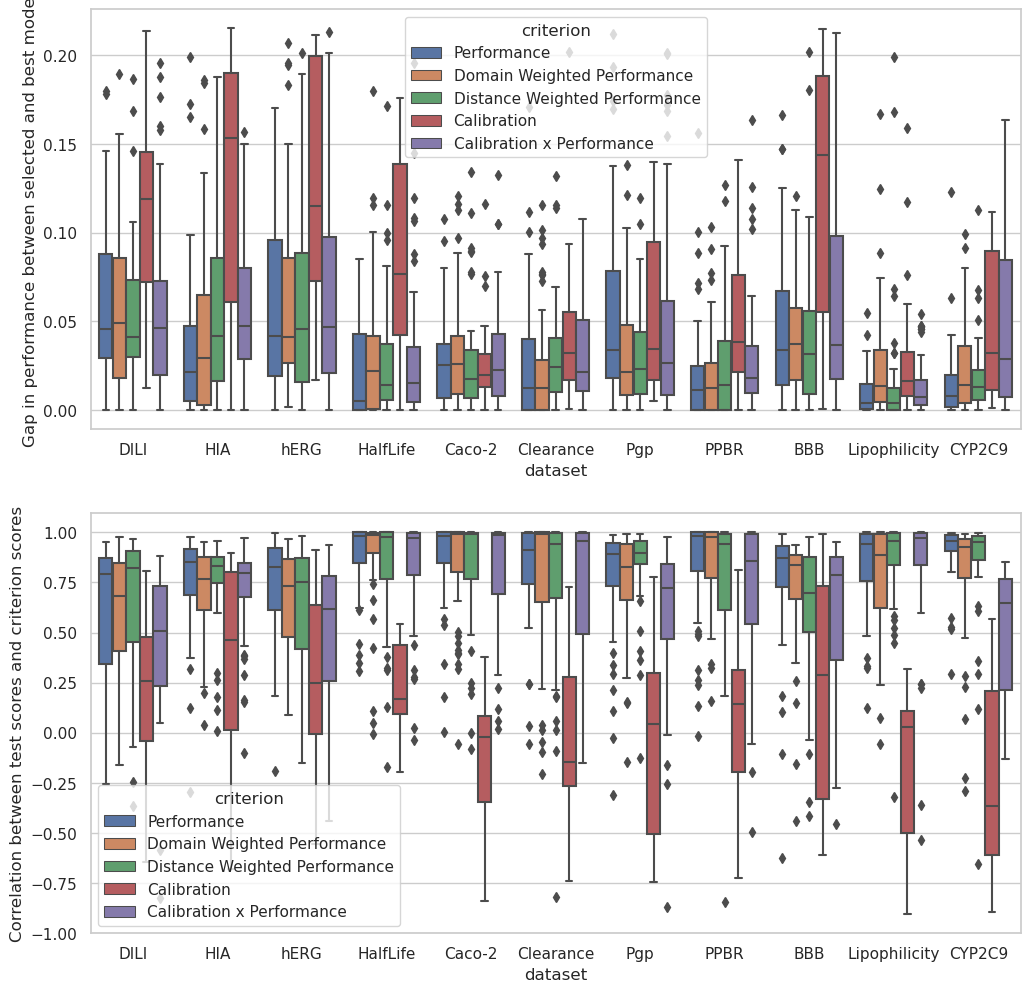

In [7]:
fig, axs = plt.subplots(nrows=2, figsize=(12, 12))
sns.boxplot(data=df, x="dataset", y="gap", hue="criterion", ax=axs[0], hue_order=MOOD_CRITERIA, order=MOOD_DATASETS)
axs[0].set_ylabel("Gap in performance between selected and best model")

sns.boxplot(data=df, x="dataset", y="corr", hue="criterion", ax=axs[1], hue_order=MOOD_CRITERIA, order=MOOD_DATASETS)
axs[1].set_ylabel("Correlation between test scores and criterion scores")

# Comparing different train-val splits

Text(0, 0.5, 'Correlation between test scores and criterion scores')

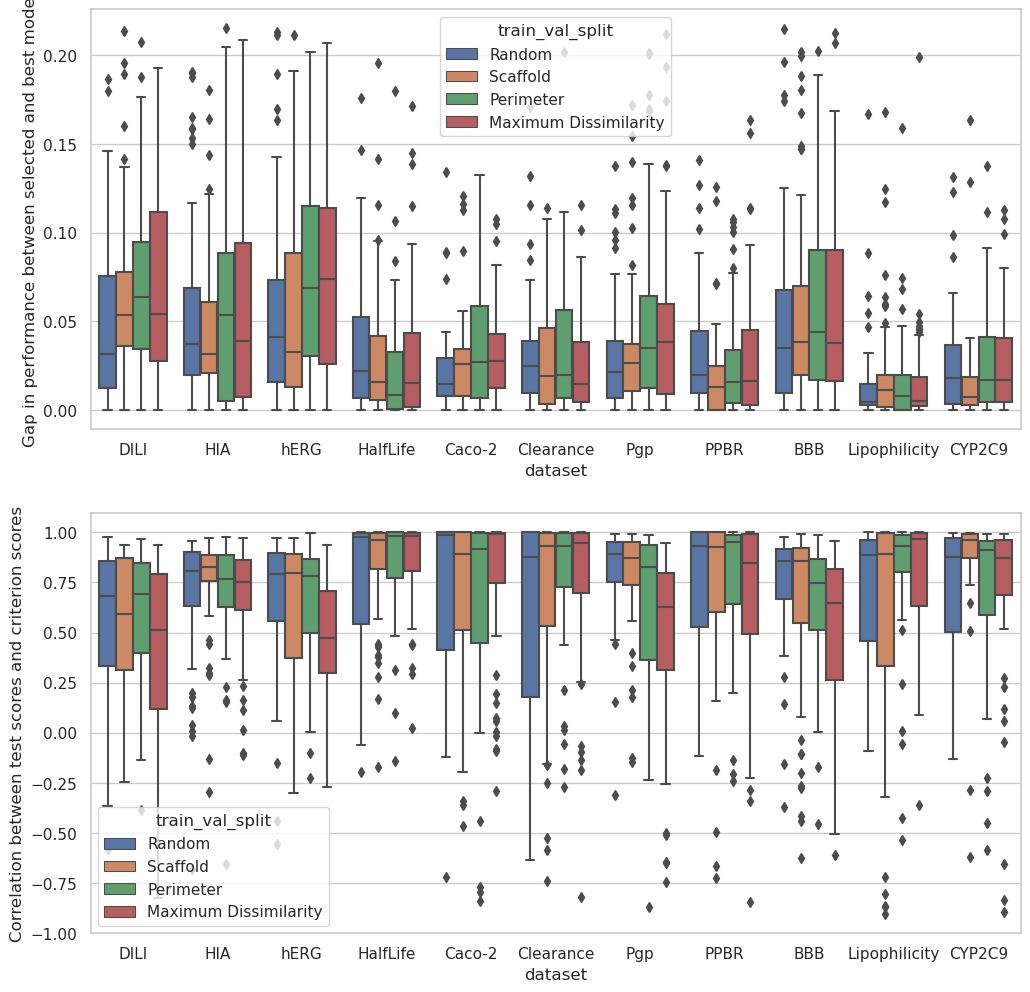

In [8]:
fig, axs = plt.subplots(nrows=2, figsize=(12, 12))
sns.boxplot(data=df, x="dataset", y="gap", hue="train_val_split", ax=axs[0], hue_order=MOOD_SPLITTERS, order=MOOD_DATASETS)
axs[0].set_ylabel("Gap in performance between selected and best model")

sns.boxplot(data=df, x="dataset", y="corr", hue="train_val_split", ax=axs[1], hue_order=MOOD_SPLITTERS, order=MOOD_DATASETS)
axs[1].set_ylabel("Correlation between test scores and criterion scores")

The End. 